In [42]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
import json
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score

import torch.utils.data
from sklearn.model_selection import train_test_split

import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import warnings
pd.set_option('display.max_columns', 500)

In [20]:
train_csv = pd.read_csv("./train.csv", keep_default_na=False)
# test_csv = pd.read_csv("./test.csv", keep_default_na=False)

In [21]:
display(train_csv.head())
print(train_csv.dtypes)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,,,,,,,,,,,,,,,,,,,,,,,,,2015-09-29 10:50:41.987077+00,2,,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,,,,,,,,,,,,,,,,,,,,,,,,,2015-09-29 10:50:42.870083+00,2,,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,,,,,,,,,,,,,,,,,,,,,,,,,2015-09-29 10:50:45.222647+00,2,,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,,,,,,,,,,,,,,,,,,,,,,,,,2015-09-29 10:50:47.601894+00,2,,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,,2006,rejected,0,0,0,1,0,0.0,4,47


id                                       int64
target                                 float64
comment_text                            object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                   object
atheist                                 object
bisexual                                object
black                                   object
buddhist                                object
christian                               object
female                                  object
heterosexual                            object
hindu                                   object
homosexual_gay_or_lesbian               object
intellectual_or_learning_disability     object
jewish                                  object
latino                                  object
male         

In [22]:
cat = len(train_csv.select_dtypes(include=['object']).columns)
num = len(train_csv.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+', num, 'numerical', '=', cat+num, 'features')

Total Features:  28 categorical + 17 numerical = 45 features


In [37]:
def fillnawithmean(column):
    column = pd.to_numeric(column, downcast='float')
    column = column.fillna(column.mean(axis = 0))
    return column


In [38]:
def transform_data(dataset):
    # num_columns = dataset.select_dtypes(include=['int64','float64']).columns
    dataset = dataset.drop(['id'],axis=1)
    dataset = dataset.drop(['article_id'],axis=1)
    dataset = dataset.drop(['parent_id'],axis=1)
    dataset = dataset.drop(['publication_id'],axis=1)
    dataset = dataset.drop(['created_date'],axis=1)
    
    num_columns = dataset.columns
    for c in num_columns:
        # dataset[c] = fillnawithmean(dataset[c])
        try:
            dataset[c] = fillnawithmean(dataset[c])
        except:
            print("An exception occurred in dataset, {} column is not a number".format(c))
    return dataset    

In [39]:
train = transform_data(train_csv)
display(train.head())

An exception occurred in dataset, comment_text column is not a number
An exception occurred in dataset, rating column is not a number


,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,0.011964,0.003205,0.001884,0.034393,0.00141,0.095268,0.12767,0.003237,0.001457,0.025611,0.001088,0.017863,0.006127,0.108687,0.04946,0.00122,0.000884,0.008248,0.006761,0.001494,0.001356,0.012083,0.006724,0.05695,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,0.011964,0.003205,0.001884,0.034393,0.00141,0.095268,0.12767,0.003237,0.001457,0.025611,0.001088,0.017863,0.006127,0.108687,0.04946,0.00122,0.000884,0.008248,0.006761,0.001494,0.001356,0.012083,0.006724,0.05695,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,0.011964,0.003205,0.001884,0.034393,0.00141,0.095268,0.12767,0.003237,0.001457,0.025611,0.001088,0.017863,0.006127,0.108687,0.04946,0.00122,0.000884,0.008248,0.006761,0.001494,0.001356,0.012083,0.006724,0.05695,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,0.011964,0.003205,0.001884,0.034393,0.00141,0.095268,0.12767,0.003237,0.001457,0.025611,0.001088,0.017863,0.006127,0.108687,0.04946,0.00122,0.000884,0.008248,0.006761,0.001494,0.001356,0.012083,0.006724,0.05695,rejected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,rejected,0.0,0.0,0.0,1.0,0.0,0.0,4.0,47.0


In [43]:
pickle.dump((train), open('testtrain.p', 'wb'))

In [44]:
train = pickle.load(open('testtrain.p', mode='rb'))

Index(['target', 'severe_toxicity', 'obscene', 'identity_attack', 'threat',
       'asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian',
       'female', 'heterosexual', 'hindu', 'homosexual_gay_or_lesbian',
       'intellectual_or_learning_disability', 'jewish', 'latino', 'male',
       'muslim', 'other_disability', 'other_gender', 'other_race_or_ethnicity',
       'other_religion', 'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')


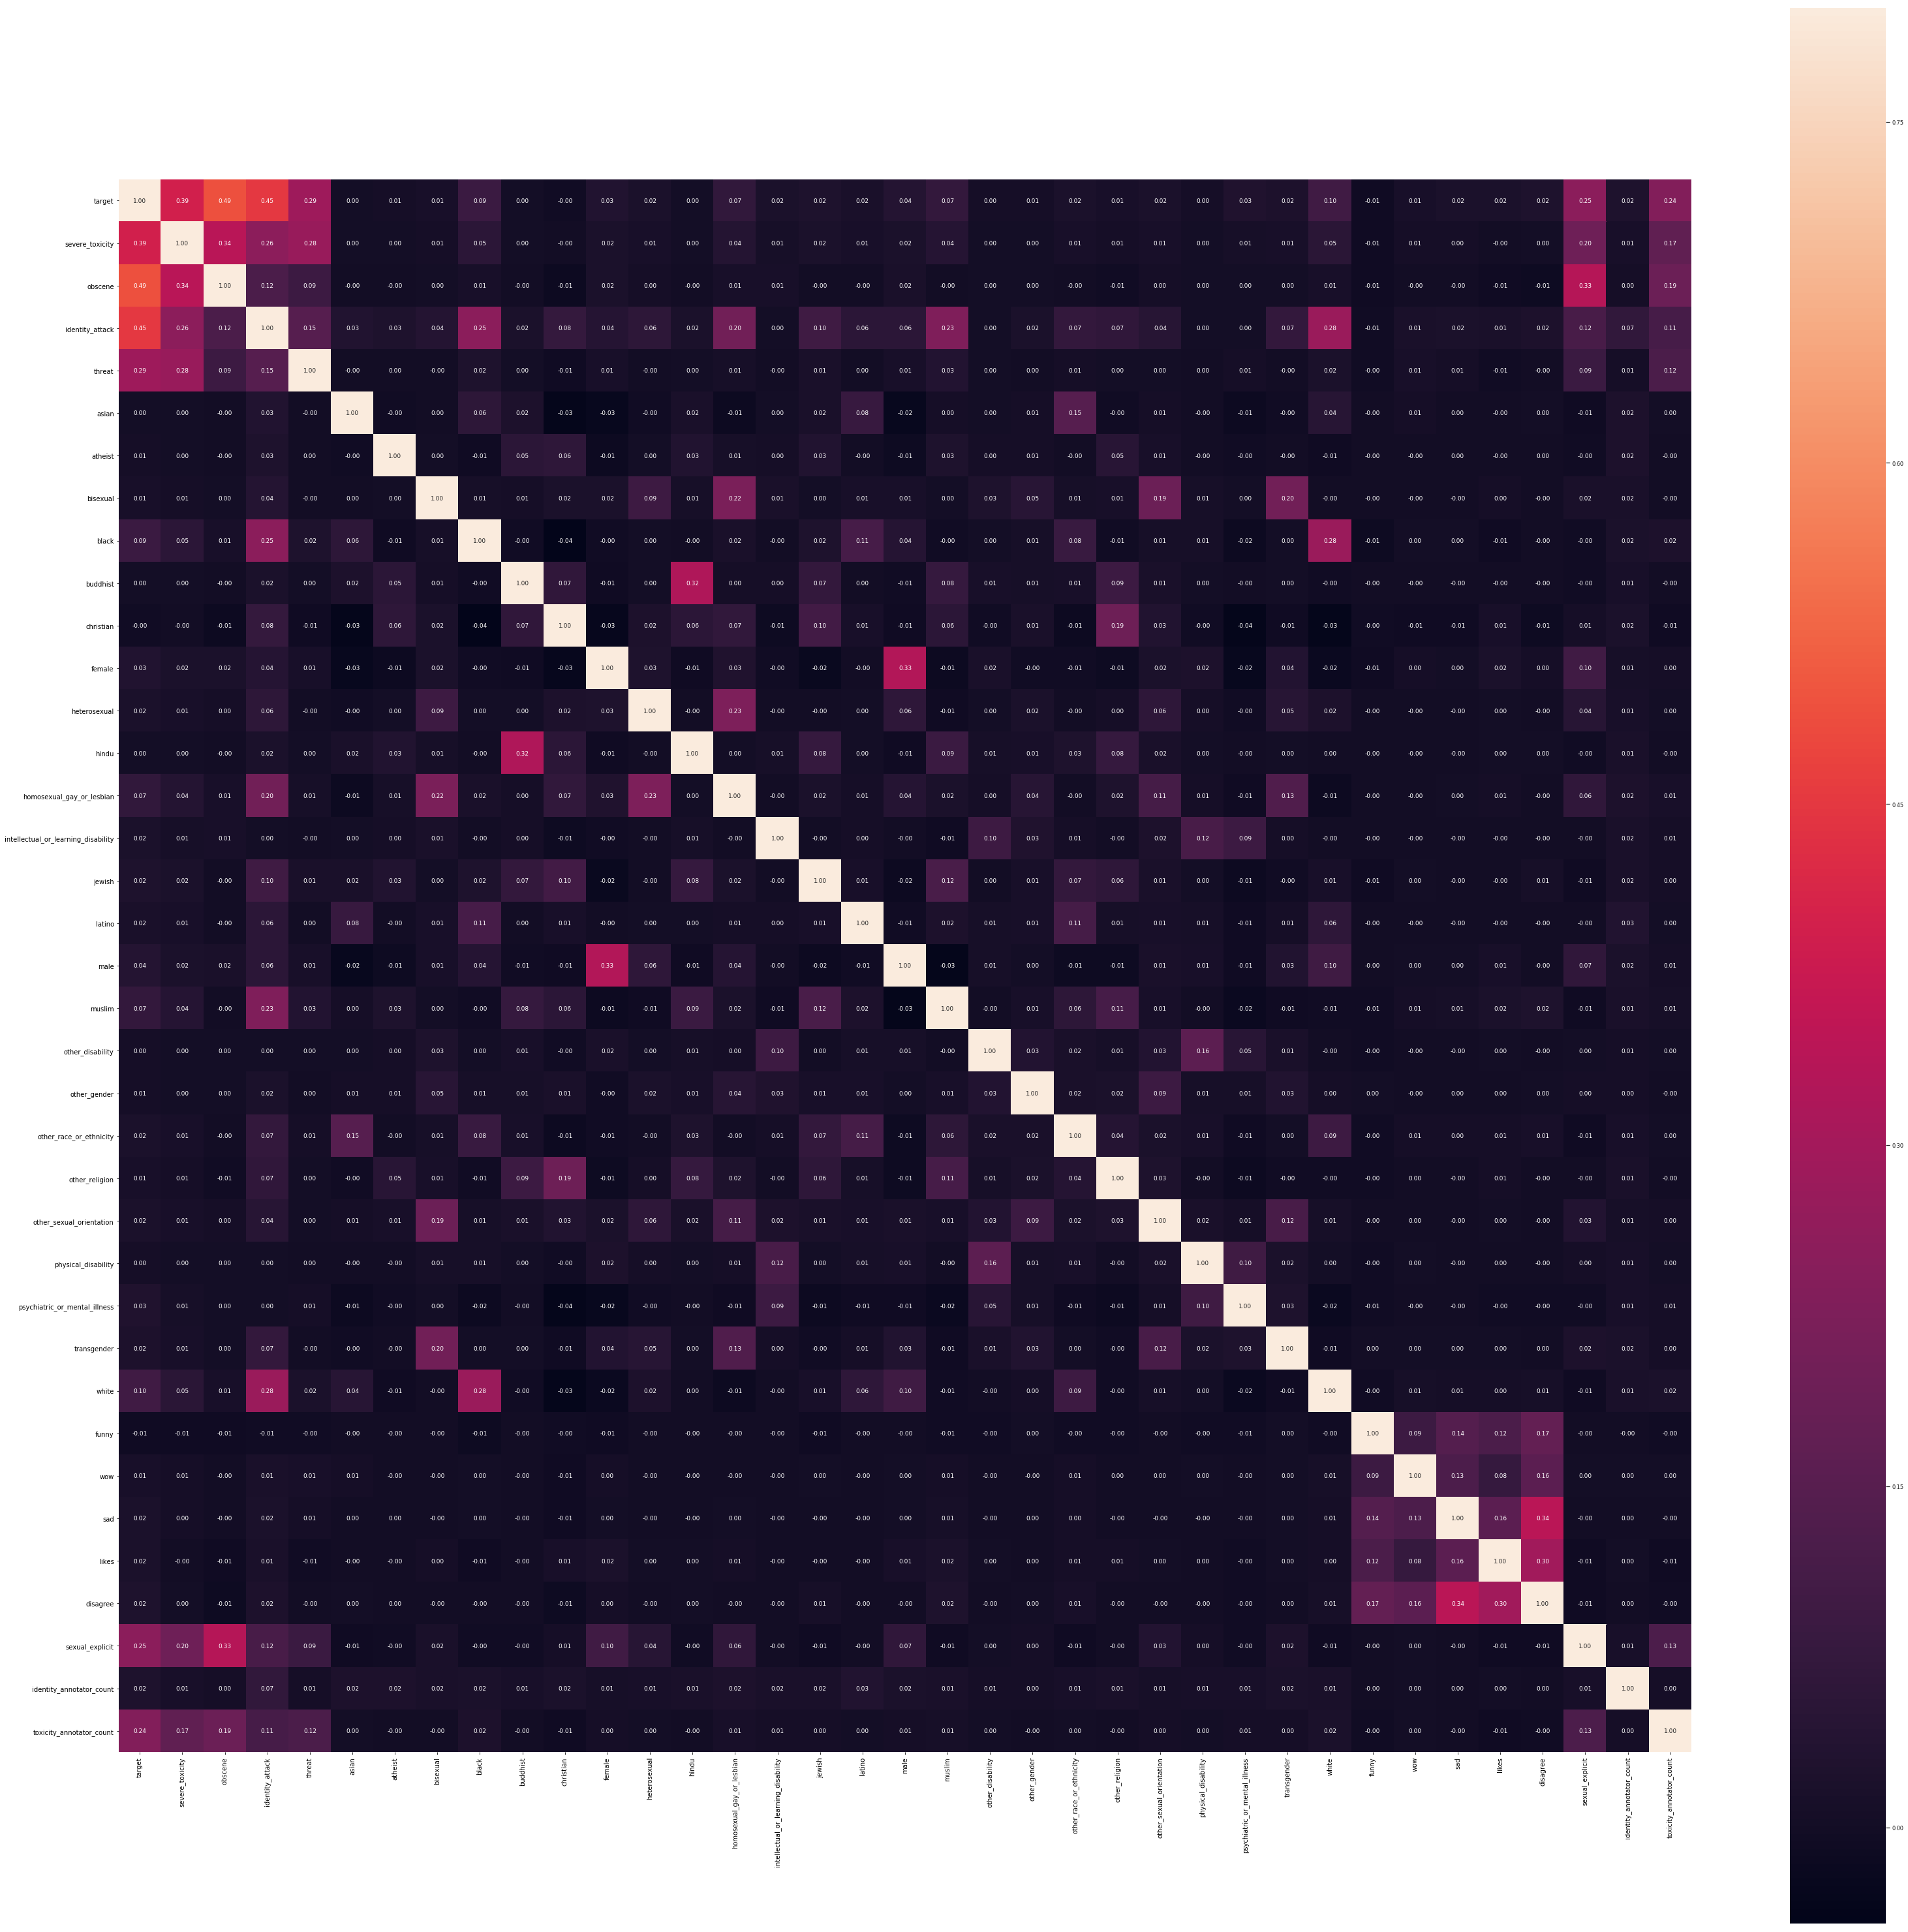

In [45]:
corr = train.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

selected_columns = corr.columns[columns]
print(selected_columns)
data = train[selected_columns]
f, ax = plt.subplots(figsize=(54, 54))
sns.set(font_scale=0.75)
sns.heatmap(data.corr(), cbar=True, annot=True, square=True, vmax=.8, fmt='.2f', yticklabels=selected_columns, xticklabels=selected_columns)
plt.show()
